# ABSA Results Data Overview
## BTT Cadence 2B

This notebook provides an overview of the processed ABSA results from 1.06M electronics reviews to help understand the data structure and basic statistics.

# Installations & Imports

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, load_dataset


# Configure display options
pd.set_option('display.max_colwidth', 180)
pd.set_option('display.max_rows', 100)

# Visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Constants
SEED = 42

# Data Loading
Loads all processed ABSA results files that are ready for dashboard visualization and analysis.

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!ls /content/drive/MyDrive/Cadence2B/absa_results/

Mounted at /content/drive
aspect_sentiments.csv  aspect_summary.csv


In [3]:
!ls /content/drive/MyDrive/Cadence2B/dashboard_data/

aspect_sentiments.csv  disagreements.csv
aspect_summary.csv     sample_reviews.csv


In [4]:
def load_absa_results():
    '''
    Load all ABSA result files into memory.

    Returns:
        tuple: (aspects_df, summary_df, disagreements_df, sample_df)
    '''

    print("Loading ABSA results...")

    # Load main aspect-sentiment pairs
    aspects_df = pd.read_csv('/content/drive/MyDrive/Cadence2B/dashboard_data/aspect_sentiments.csv')
    print(f"- Loaded {len(aspects_df):,} aspect-sentiment pairs")

    # Load aggregated summary
    summary_df = pd.read_csv('/content/drive/MyDrive/Cadence2B/dashboard_data/aspect_summary.csv')
    print(f"- Loaded {len(summary_df):,} unique aspects")

    # Load disagreement cases (if ratings exist)
    try:
        disagreements_df = pd.read_csv('/content/drive/MyDrive/Cadence2B/dashboard_data/disagreements.csv')
        print(f"- Loaded {len(disagreements_df):,} disagreement cases")
    except FileNotFoundError:
        print("(X) No disagreements.csv found (ratings may not be available)")
        disagreements_df = pd.DataFrame()

    # Load sample reviews for context
    try:
        sample_df = pd.read_csv('/content/drive/MyDrive/Cadence2B/dashboard_data/sample_reviews.csv')
        print(f"- Loaded {len(sample_df):,} sample reviews\n")
    except FileNotFoundError:
        print("(X) No sample_reviews.csv found\n")
        sample_df = pd.DataFrame()

    return aspects_df, summary_df, disagreements_df, sample_df

In [5]:
# Load all data
aspects_df, summary_df, disagreements_df, sample_df = load_absa_results()

Loading ABSA results...
- Loaded 918,167 aspect-sentiment pairs
- Loaded 93,033 unique aspects
- Loaded 194,295 disagreement cases
- Loaded 1,000 sample reviews



In [6]:
print("=" * 80)
print("ASPECT-SENTIMENT PAIRS STRUCTURE")
print("=" * 80)
aspects_df.info()
print("\nSample rows:")
print(aspects_df.head(10))

print("\n" + "=" * 80)
print("ASPECT SUMMARY STRUCTURE")
print("=" * 80)
summary_df.info()
print("\nTop 20 aspects by frequency:")
print(summary_df.head(20))

ASPECT-SENTIMENT PAIRS STRUCTURE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918167 entries, 0 to 918166
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   review_id        918167 non-null  int64  
 1   aspect           918167 non-null  object 
 2   sentiment        918167 non-null  object 
 3   sentiment_score  918167 non-null  float64
 4   text             918167 non-null  object 
 5   rating           918167 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 42.0+ MB

Sample rows:
   review_id               aspect sentiment  sentiment_score  \
0          1  What a beautiful TV  positive         0.947066   
1          2               cables   neutral         0.748858   
2          2        every adapter   neutral         0.817963   
3          2             backpack  positive         0.611000   
4          5               camera   neutral         0.656025   
5          6        

# Overall Statistics

In [7]:
def display_overall_stats(aspects_df, summary_df):
    '''
    Display high-level statistics about the ABSA results.

    Parameters:
        aspects_df: DataFrame with all aspect-sentiment pairs
        summary_df: DataFrame with aggregated aspect statistics
    '''

    print("\n" + "=" * 80)
    print("OVERALL STATISTICS")
    print("=" * 80)

    # Dataset size
    print(f"\nDataset Size:")
    print(f"  Total aspect-sentiment pairs: {len(aspects_df):,}")
    print(f"  Unique aspects identified:    {aspects_df['aspect'].nunique():,}")

    # Check if review_id exists
    if 'review_id' in aspects_df.columns:
        print(f"  Unique reviews analyzed:      {aspects_df['review_id'].nunique():,}")

    # Sentiment distribution
    print(f"\nSentiment Distribution:")
    sentiment_counts = aspects_df['sentiment'].value_counts()
    total = len(aspects_df)
    for sentiment, count in sentiment_counts.items():
        percentage = (count / total) * 100
        print(f"  {sentiment.capitalize():<10}: {count:>8,} ({percentage:>5.1f}%)")

    # Aspect frequency distribution
    print(f"\nAspect Frequency Distribution:")
    print(f"  Aspects mentioned 1000+ times:  {(summary_df['total'] >= 1000).sum():,}")
    print(f"  Aspects mentioned 100-999 times: {((summary_df['total'] >= 100) & (summary_df['total'] < 1000)).sum():,}")
    print(f"  Aspects mentioned 10-99 times:   {((summary_df['total'] >= 10) & (summary_df['total'] < 100)).sum():,}")
    print(f"  Aspects mentioned <10 times:     {(summary_df['total'] < 10).sum():,}")

In [8]:
display_overall_stats(aspects_df, summary_df)


OVERALL STATISTICS

Dataset Size:
  Total aspect-sentiment pairs: 918,167
  Unique aspects identified:    93,033
  Unique reviews analyzed:      444,573

Sentiment Distribution:
  Neutral   :  336,224 ( 36.6%)
  Positive  :  312,796 ( 34.1%)
  Negative  :  269,147 ( 29.3%)

Aspect Frequency Distribution:
  Aspects mentioned 1000+ times:  97
  Aspects mentioned 100-999 times: 735
  Aspects mentioned 10-99 times:   12,969
  Aspects mentioned <10 times:     79,232


# Sentiment Distribution Plot

In [9]:
def plot_sentiment_distribution(aspects_df):
    '''
    Visualize overall sentiment distribution as a pie chart.

    Parameters:
        aspects_df: DataFrame with aspect-sentiment pairs
    '''

    sentiment_counts = aspects_df['sentiment'].value_counts()

    # Color mapping for consistency
    colors = {
        'positive': '#2ecc71',
        'neutral': '#95a5a6',
        'negative': '#e74c3c'
    }

    plt.figure(figsize=(10, 6))
    plt.pie(
        sentiment_counts.values,
        labels=[s.capitalize() for s in sentiment_counts.index],
        autopct='%1.1f%%',
        colors=[colors.get(s, '#3498db') for s in sentiment_counts.index],
        startangle=90
    )
    plt.title('Overall Sentiment Distribution\n(918K Aspect-Sentiment Pairs)',
              fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

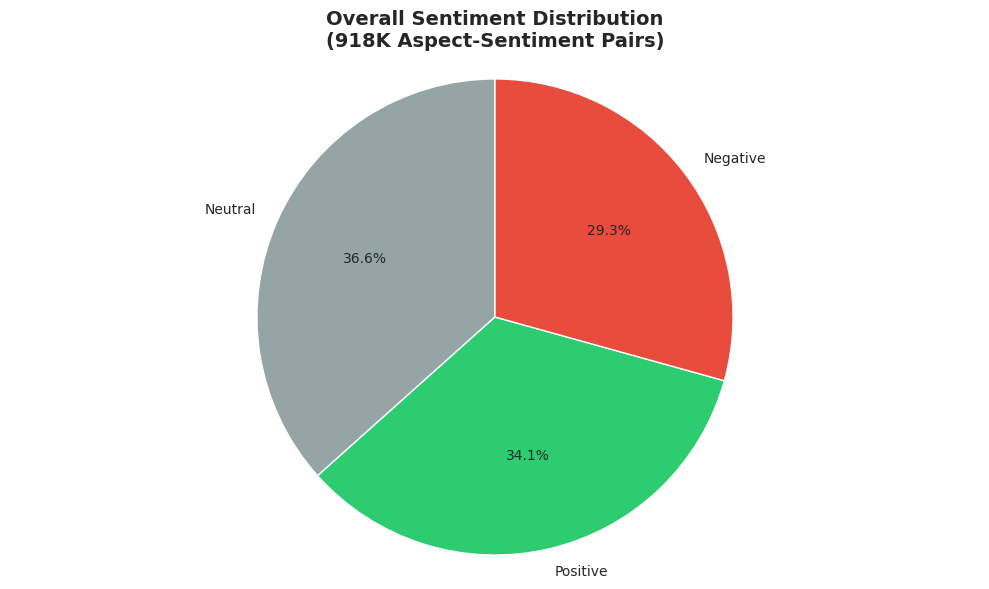

In [10]:
plot_sentiment_distribution(aspects_df)

# Visualize Top 20 Aspects

In [11]:
def plot_top_aspects(summary_df, n=20):
    '''
    Display top N aspects by total mention frequency.

    Parameters:
        summary_df: Aggregated aspect statistics
        n: Number of top aspects to display
    '''

    top_aspects = summary_df.head(n)

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_aspects)), top_aspects['total'], color='#3498db')
    plt.yticks(range(len(top_aspects)), top_aspects['aspect'])
    plt.xlabel('Total Mentions', fontsize=12)
    plt.title(f'Top {n} Most Discussed Product Aspects', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Highest at top

    # Add count labels
    for i, (idx, row) in enumerate(top_aspects.iterrows()):
        plt.text(row['total'] + 200, i, f"{row['total']:,}",
                va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

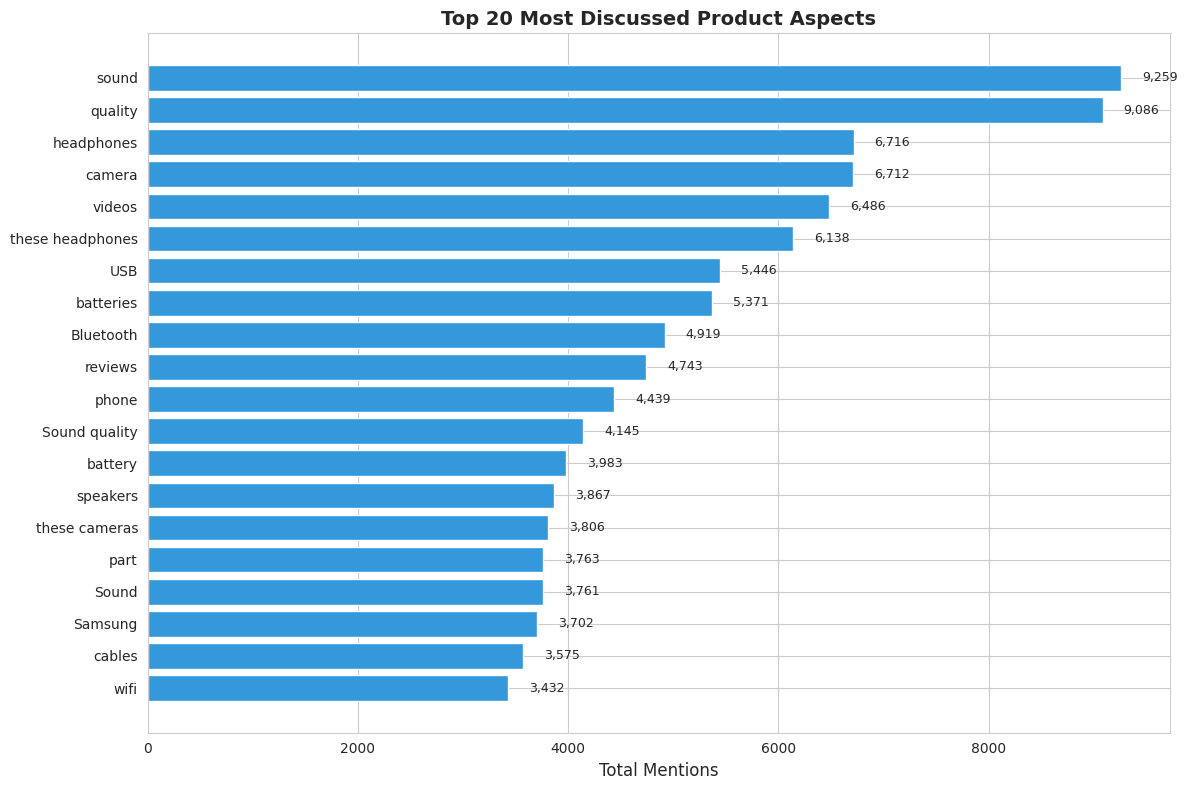

In [12]:
plot_top_aspects(summary_df, n=20)

# Visualize Aspects Per Review

In [16]:
def plot_aspects_per_review(aspects_df):
    '''
    Show distribution of how many aspects are extracted per review.

    Parameters:
        aspects_df: DataFrame with aspect-sentiment pairs
    '''

    # Check if review_id exists
    if 'review_id' not in aspects_df.columns:
        print("(X)  Cannot plot aspects per review - no review_id column found")
        return

    aspects_per_review = aspects_df.groupby('review_id').size()

    plt.figure(figsize=(12, 6))
    plt.hist(aspects_per_review, bins=50, color='#e67e22', alpha=0.7, edgecolor='black')
    plt.axvline(aspects_per_review.mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {aspects_per_review.mean():.2f}')
    plt.xlabel('Number of Aspects per Review', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Aspects Extracted per Review', fontsize=14, fontweight='bold')
    plt.legend()
    plt.xlim(0, 20)  # main distribution
    plt.tight_layout()
    plt.show()

    print(f"\nAspects per review statistics:")
    print(f"  Mean:   {aspects_per_review.mean():.2f}")
    print(f"  Median: {aspects_per_review.median():.1f}")
    print(f"  Max:    {aspects_per_review.max()}")

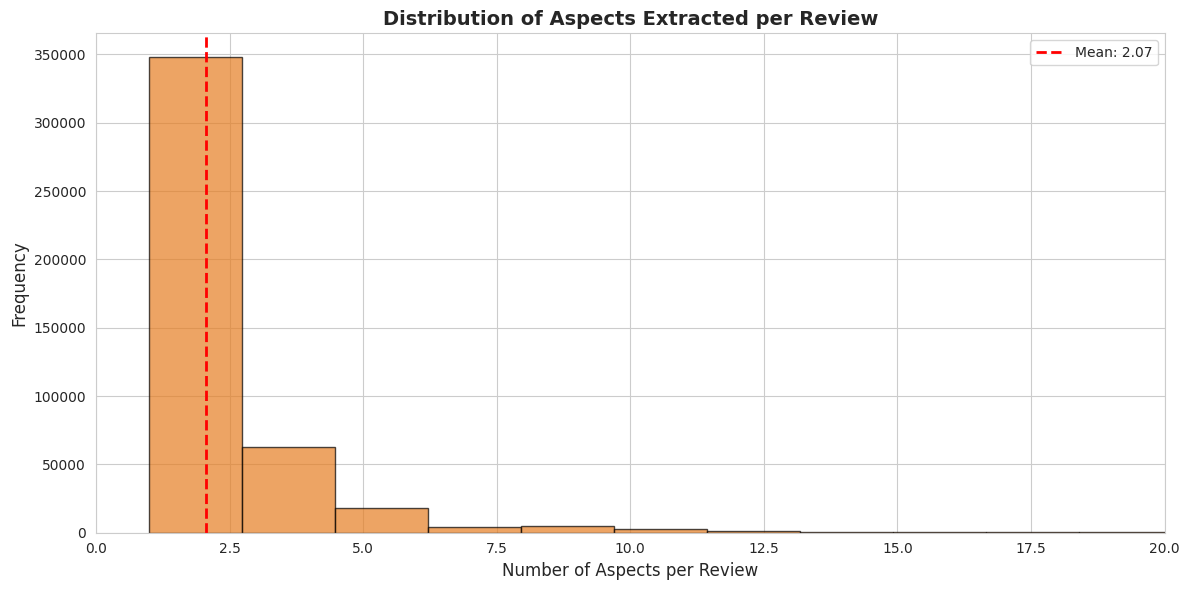


Aspects per review statistics:
  Mean:   2.07
  Median: 1.0
  Max:    88


In [17]:
plot_aspects_per_review(aspects_df)

In [18]:
print("\n" + "=" * 80)
print("SAMPLE ASPECT-SENTIMENT PAIRS")
print("=" * 80)

# Show examples for each sentiment
for sentiment in ['positive', 'negative', 'neutral']:
    print(f"\n{sentiment.upper()} Examples:")
    sentiment_data = aspects_df[aspects_df['sentiment'] == sentiment]

    if len(sentiment_data) > 0:
        examples = sentiment_data.sample(min(3, len(sentiment_data)), random_state=SEED)
        for idx, row in examples.iterrows():
            print(f"\nAspect: {row['aspect']}")
            print(f"Review: {row['text'][:150]}...")
            print("-" * 80)




SAMPLE ASPECT-SENTIMENT PAIRS

POSITIVE Examples:

Aspect: different ust projector way cheaper and much much better picture quality
Review: I have different ust projector way cheaper and much much better picture quality with auto focus epson has manual focus hard to make it right ots going...
--------------------------------------------------------------------------------

Aspect: all the filters
Review: just got these babies in the mail today and tried on right away on my Nikon 58mm 1.8 and they fit perfectly. all the filters work perfectly. the only ...
--------------------------------------------------------------------------------

Aspect: ergonomic design
Review: I have a Paperwhite and a Voyage, but I read a lot and finally gave into temptation and picked up the Oasis recently as well. They all get the job don...
--------------------------------------------------------------------------------

NEGATIVE Examples:

Aspect: these drives
Review: I've had 2 new ones, both failed with